## VARIANTS STUFF

In [ ]:
def get_variant_filepaths(sample_ids: list) -> dict:
    variant_paths = {}
    for s_id in sample_ids:
        f = !find /home/gk/analysis/ -type f -path '*variants*' -name *{s_id}*
        variant_paths[s_id] = f[0]
    return variant_paths
# test = get_variant_filepaths([sample_id])


def find_loc(f: str):
    return f.split('/')[-1].split('_')[0].split('-')[-1]

def get_variant_data(variant_filepaths: dict):
    df = (pd.concat((pd.read_csv(f, sep='\t')
                     .assign(sample=s_id, location=find_loc(f)) for s_id, f in variant_filepaths.items())))
    return df

def get_del_positions(del_coords: pd.Series) -> list:
    return del_coords.apply(lambda x: int(x.split(':')[0])+265).tolist()
# def identify_isnv_deletions(sample_ids: list)
del_positions = get_del_positions(del_seqs['del_coords'])
# TODO
vfp = get_variant_filepaths(sample_ids=SAMPLE_IDS)
test = get_variant_data(vfp)
test = (test.loc[(test['ALT'].str.contains('-'))
                &(test['POS'].isin(del_positions))
                &(test['sample'].isin(nondel_ids))]
        [['sample', 'REGION', 'POS', 'REF', 'ALT', 'ALT_FREQ']])
del_idxs = test.groupby('sample')['ALT_FREQ'].transform(max) == test['ALT_FREQ']
test = test[del_idxs]
test

In [174]:
# tree.get_terminals()
int(1.7)

1

In [157]:
sample_ids = [eval(n.name.split('-')[1]) for n in tree.get_terminals() if len(n.name.split('-')) >= 3]
deletion_ids = [eval(s.split('-')[1]) for s in deletion_samples]
non_del_ids = set(sample_ids) - set(deletion_ids)
# sanity check (ignoring patient zero)
assert len(deletion_ids) == len(tree.get_terminals()) - len(non_del_samples) - 1

In [171]:
sample_colors

{'SEARCH-3903-JOR': 'tab:blue',
 'SEARCH-3906-JOR': 'tab:blue',
 'SEARCH-3930-JOR': 'tab:blue',
 'SEARCH-3940-JOR': 'tab:blue',
 'SEARCH-3941-JOR': 'tab:blue',
 'SEARCH-3951-JOR': 'tab:blue',
 'SEARCH-3966-JOR': 'tab:blue',
 'SEARCH-3967-JOR': 'tab:blue',
 'SEARCH-3986-JOR': 'tab:blue',
 'SEARCH-3987-JOR': 'tab:blue',
 'SEARCH-3990-JOR': 'tab:blue',
 'SEARCH-3991-JOR': 'tab:blue',
 'SEARCH-3992-JOR': 'tab:blue',
 'SEARCH-4009-JOR': 'tab:blue',
 'SEARCH-4020-JOR': 'tab:blue',
 'SEARCH-4021-JOR': 'tab:blue',
 'SEARCH-4025-JOR': 'tab:blue',
 'SEARCH-4035-JOR': 'tab:blue',
 'SEARCH-4036-JOR': 'tab:blue',
 'SEARCH-4054-JOR': 'tab:blue',
 'SEARCH-4055-JOR': 'tab:blue',
 'SEARCH-4059-JOR': 'tab:blue',
 'SEARCH-4086-JOR': 'tab:blue',
 'SEARCH-4087-JOR': 'tab:blue',
 'SEARCH-4088-JOR': 'tab:blue',
 'SEARCH-4089-JOR': 'tab:blue',
 'SEARCH-4098-JOR': 'tab:blue',
 'SEARCH-2285-SAN': 'tab:orange',
 'SEARCH-2286-SAN': 'tab:orange',
 'SEARCH-2366-SAN': 'tab:orange',
 'SEARCH-2379-SAN': 'tab:orange',


In [169]:
del_seqs['del_coords'].apply(lambda x: int(x.split(':')[0])+265).tolist()

[28089, 685, 29471, 26157, 28889, 28089]

In [170]:
del_seqs

,del_coords,del_len,samples,num_samples
22,27824:27829,6,"[SEARCH-2294-SAN, SEARCH-2393-SAN, SEARCH-2437...",4
29,420:428,9,"[SEARCH-2420-SAN, SEARCH-3811-SAN, SEARCH-3969...",4
27,29206:29211,6,"[SEARCH-3034-SAN, SEARCH-3129-SAN, SEARCH-3143...",5
11,25892:25895,4,"[SEARCH-2907-SAN, SEARCH-2913-SAN, SEARCH-2926...",7
25,28624:28635,12,"[SEARCH-2285-SAN, SEARCH-2286-SAN, SEARCH-2366...",20
21,27824:27826,3,"[SEARCH-3903-JOR, SEARCH-3906-JOR, SEARCH-3930...",27


In [148]:
len(deletion_ids)

67

In [126]:
ref_seq[27824:27827]

'atg'

In [127]:
[3971, 3934, 4026, 4010, 4001, 
 3956, 3955, 3954, 3953, 3947, 
 3946, 3942, 3925, 3904, 3939, 
 4023, 4019, 3970, 3969]

-1

In [113]:
patient_zero = 'NC_045512.2'

In [122]:
# import toytree
import numpy as np
import pandas as pd
import re
import dendropy
from itertools import groupby
import more_itertools as mit
from operator import itemgetter
import matplotlib.pylab as plt
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from Bio import SeqIO, AlignIO, Phylo

In [123]:
colors = list(mcolors.TABLEAU_COLORS.keys())

## CONSENSUS STUFF

In [116]:
# type(tree)

In [117]:
# path to FASTA with consensus sequences
filepath = "/Users/al/Documents/scripps/data/tree_expts/msa.fa"

In [118]:
# support functions
def get_seqs(bio_seqs, min_pos: int=265, max_pos: int=29674) -> dict:
    seqs = {}
    for row in bio_seqs:
        sample_idx = str(row.id)
        s = str(row.seq)
        seqs[sample_idx] = s[min_pos:max_pos]
    return seqs

def find_del_positions(x):
    return [m.start() for m in re.finditer('-', x)]

def find_deletions(x):
    del_positions = [m.start() for m in re.finditer('-', x)]
    return [list(map(itemgetter(1), g)) for k, g in groupby(enumerate(del_positions), 
                                                            lambda x: x[0]-x[1])]

def find_deletions_v2(x):
    del_positions = [m.start() for m in re.finditer('-', x)]
    deletions = [list(deletion) for deletion in mit.consecutive_groups(del_positions)]
    return deletions

def cross_join(df1: pd.DataFrame, df2: pd.DataFrame) -> pd.DataFrame:
    df1 = df1.assign(key=0)
    df2 = df2.assign(key=0)
    return pd.merge(df1, df2, on='key').drop(columns='key')

def is_deletion_common(x):
    return x['del_positions_x']==x['del_positions_y']

def get_deletion_coord(x):
    min_pos = np.min(x)
    max_pos = np.max(x)
    return f'{min_pos}:{max_pos}'

In [119]:
def identify_deletions(input_filepath: str, patient_zero: str, min_del_len: int=2) -> pd.DataFrame:
    # read MSA file
    consensus_data = AlignIO.read(input_filepath, 'fasta')
    ref_seq = get_seq(consensus_data, patient_zero)
    insertion_positions = identify_insertion_positions(ref_seq)
    # remove insertions from each sequence to consolidate correct nt positions
    for rec in consensus_data:
        rec.seq = remove_insertions(str(rec.seq), insertion_positions)
    # sanity check: ensure that there are no "fake" deletions in reference sequence
    ref_seq = get_seq(consensus_data, patient_zero)
    assert not identify_insertion_positions(ref_seq)
    # grab sequences from MSA
    seqs = get_seqs(consensus_data)
    # load into dataframe
    seqsdf = (pd.DataFrame(index=seqs.keys(), data=seqs.values(), columns=['sequence'])
                .reset_index().rename(columns={'index': 'idx'}))
    seqsdf['seq_len'] = seqsdf['sequence'].str.len()
    seqsdf['del_positions'] = seqsdf['sequence'].apply(find_deletions_v2)
    # sequences with one or more deletions
    del_seqs = seqsdf.loc[seqsdf['del_positions'].str.len() > 0]
    del_seqs = del_seqs.explode('del_positions')
    # compute length of each deletion
    del_seqs['del_len'] = del_seqs['del_positions'].apply(len)
    # only consider deletions longer than 2nts
    del_seqs = del_seqs[del_seqs['del_len'] > min_del_len]
    # fetch coordinates of each deletion
    del_seqs['del_coords'] = del_seqs['del_positions'].apply(get_deletion_coord)
    # group sample by the deletion they share
    del_seqs = (del_seqs.groupby(['del_coords', 'del_len'])
                        .agg(samples=('idx', 'unique'),       # list of sample IDs with the deletion
                             num_samples=('idx', 'nunique'))  # num of samples with the deletion
                        .reset_index()
                        .sort_values('num_samples'))
    return del_seqs

In [120]:
def get_seq(all_seqs, sample_name: str) -> str:
    for rec in all_seqs:
        if rec.name == sample_name:
            seq = rec.seq
            break
    return str(seq)

def identify_insertion_positions(ref_seq: str) -> list:
    return [m.start() for m in re.finditer('-', str(ref_seq))]

def remove_insertions(seq: str, positions: list) -> str:
    for i, pos in enumerate(positions):
        seq = seq[:pos-i] + seq[pos+1-i:]
    return seq

In [121]:
deletions = identify_deletions(filepath, patient_zero=patient_zero)
deletions

,del_coords,del_len,samples,num_samples
0,157:159,3,[SEARCH-3873-SAN],1
28,29308:29322,15,[SEARCH-2405-SAN],1
26,29160:29175,16,[SEARCH-2505-TIJ],1
24,2824:2844,21,[SEARCH-3730-SAN],1
19,27529:27531,3,[SEARCH-2022-SAN],1
18,27528:27531,4,[SEARCH-3934-JOR],1
16,27431:27484,54,[SEARCH-4026-JOR],1
30,602:625,24,[SEARCH-3882-SAN],1
12,26998:27024,27,[SEARCH-3236-SAN],1
15,27412:27430,19,[SEARCH-2117-SAN],1


In [80]:
# temporary fix to "pseudo" deletions
del_seqs = del_seqs[(del_seqs['num_samples'] > 2)]
del_seqs

,del_coords,del_len,samples,num_samples
22,27824:27829,6,"[SEARCH-2294-SAN, SEARCH-2393-SAN, SEARCH-2437...",4
29,420:428,9,"[SEARCH-2420-SAN, SEARCH-3811-SAN, SEARCH-3969...",4
27,29206:29211,6,"[SEARCH-3034-SAN, SEARCH-3129-SAN, SEARCH-3143...",5
11,25892:25895,4,"[SEARCH-2907-SAN, SEARCH-2913-SAN, SEARCH-2926...",7
25,28624:28635,12,"[SEARCH-2285-SAN, SEARCH-2286-SAN, SEARCH-2366...",20
21,27824:27826,3,"[SEARCH-3903-JOR, SEARCH-3906-JOR, SEARCH-3930...",27


In [81]:
# deletions

In [82]:
output_filepath = '/Users/al/Documents/scripps/data/covid_release_1/consensus_deletions.csv'

In [83]:
del_seqs.to_csv(output_filepath, index=False)

In [84]:
deletions = pd.read_csv(output_filepath)

In [85]:
deletions[deletions['del_len'] > 1]
deletions['samples'] = deletions['samples'].apply(lambda x: x[1:-1].split())
# deletions['samples'] = deletions['samples'].apply(lambda x: x[1:-1].split())
top_deletions = deletions.sort_values('num_samples', ascending=False)

In [111]:
top_deletions.loc[top_deletions['del_coords']=='420:428', 'samples'].values

array([list(["'SEARCH-2420-SAN'", "'SEARCH-3811-SAN'", "'SEARCH-3969-JOR'", "'SEARCH-3970-JOR'"])],
      dtype=object)

In [87]:
# top_deletions

In [88]:
# TODO: specify `colors` dynamically based on number of distinct deletions
def get_del2color(deletions: pd.DataFrame) -> dict:
    del2color = {}
    for i, td in enumerate(deletions.iterrows()):
        deletion = td[1]['del_coords']
        del2color[deletion] = colors[i]
    return del2color
del2color = get_del2color(top_deletions)
del2color

{'27824:27826': 'tab:blue',
 '28624:28635': 'tab:orange',
 '25892:25895': 'tab:green',
 '29206:29211': 'tab:red',
 '27824:27829': 'tab:purple',
 '420:428': 'tab:brown'}

In [89]:
def get_sample2color(deletions: pd.DataFrame) -> dict:
    sample_colors = {}
    del2color = get_del2color(deletions)
    for i, td in enumerate(deletions.iterrows()):
        deletion = td[1]['del_coords']
        samples = td[1]['samples']
        for sample in samples:
#             print(sample)
            sample_colors[eval(sample)] = del2color[deletion]
    return sample_colors
sample_colors = get_sample2color(top_deletions)
len(sample_colors)

67

In [90]:
def get_color_legends(del2color: dict) -> list:
    legend_elements = [Line2D([0], [0], marker='o', color=x, label=y,
                       markerfacecolor=x, markersize=15) for y, x in del2color.items()]
    return legend_elements
legend = get_color_legends(del2color)
legend

In [91]:
tree_path = "/Users/al/Documents/scripps/data/tree_expts/msa.fa.treefile"

In [92]:
tree = next(Phylo.parse(tree_path, 'newick'))
tree.rooted
# root with genome from patient zero
root_name = 'NC_045512.2'
tree.root_with_outgroup(root_name)
tree.rooted

True

In [93]:
len(tree.get_terminals())


1206

In [94]:
def prune_clade(clade: Phylo.Newick.Clade, samples_of_interest: list) -> bool:
    sample_names = [leaf.name for leaf in clade.get_terminals()]
    common_names = set(sample_names) & set(samples_of_interest)
    if len(common_names) == 0:
        clade._set_color('red')
        return True
    return False

In [95]:
deletion_samples = list(sample_colors.keys())

In [96]:
# deletion_samples

In [97]:
Phylo.Newick.Clade

Bio.Phylo.Newick.Clade

In [98]:
prune_samples = set()
for clade in tree.get_nonterminals():
#     print(prune_clade(clade, deletion_samples))
    if prune_clade(clade, deletion_samples):
#         clade.clades = clade
        prune_samples.update([leaf for leaf in clade.get_terminals()])
print(len(prune_samples))

963


In [99]:
# tree.get_nonterminals()[0].x

In [100]:
tree.get_terminals()[0]

Clade(branch_length=8.729e-07, name='SEARCH-1996-SAN')

In [101]:
# dir(tree)

In [102]:
for sample in prune_samples:
#     print(sample)
    tree.prune(sample)

In [103]:
len(tree.get_terminals())

243

In [104]:
def get_coords(tree):
    for _i, i in enumerate(tree.get_terminals()):
        i.y = _i
        i.x = tree.distance(i)

    for i in reversed(tree.get_nonterminals()):
        _ = i.clades
        i.y = (_[0].y + _[-1].y)/2
        i.x = tree.distance(i)
    return tree

In [105]:
tree = get_coords(tree)

In [106]:
plt.rcParams["figure.figsize"] = (40,100)

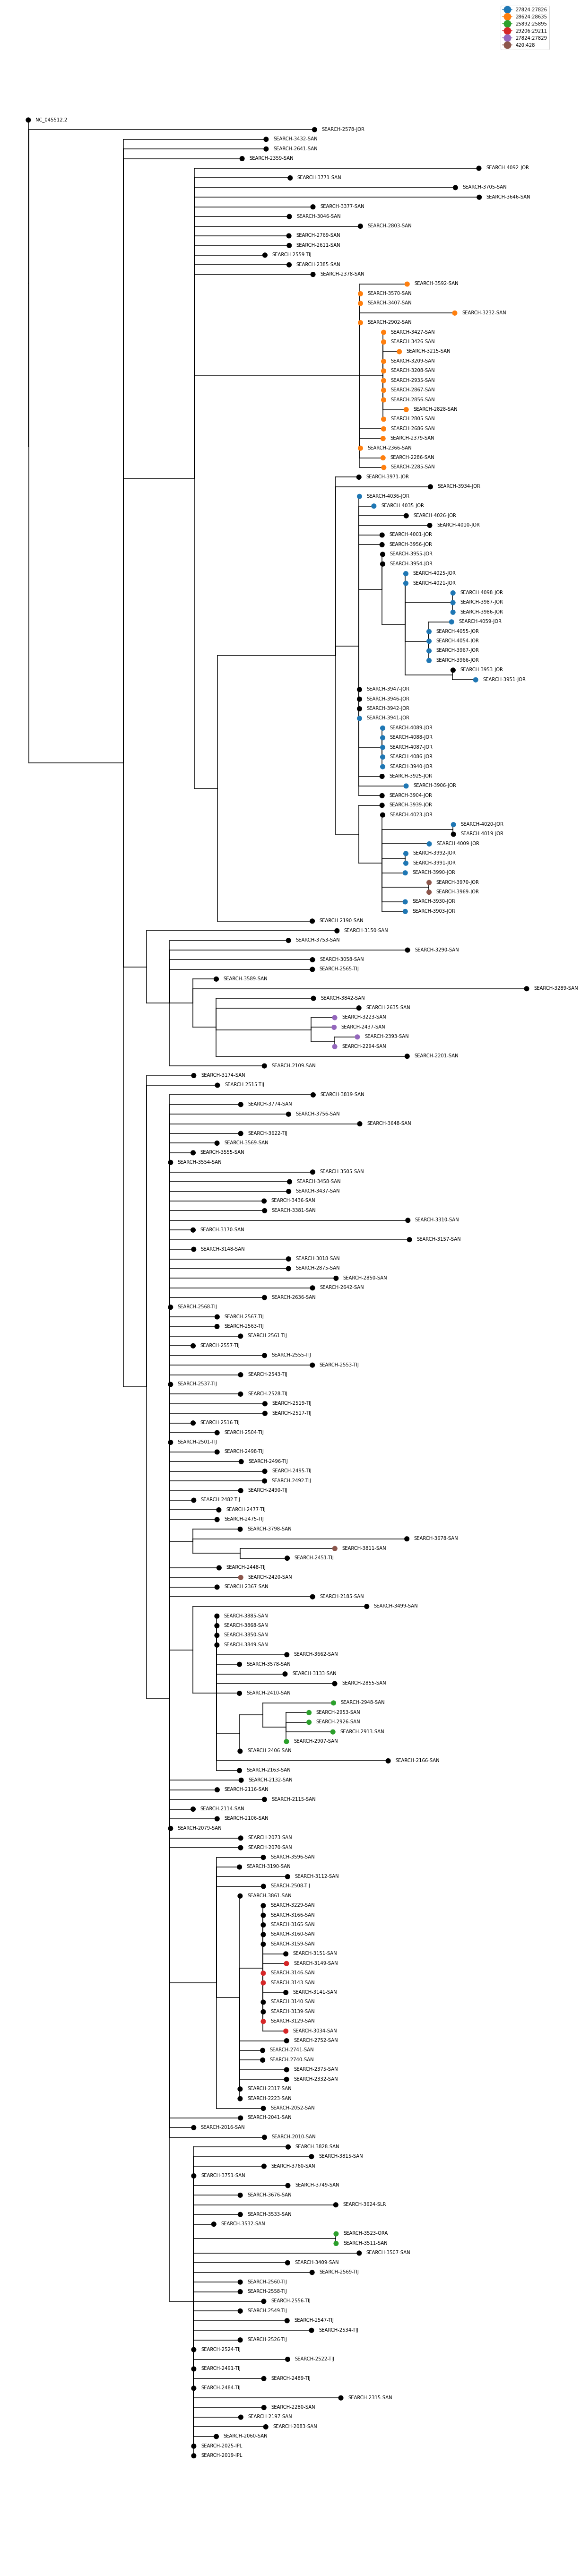

In [107]:
f = plt.figure()
gs = gridspec.GridSpec(2, 2, width_ratios=[1,0.75], height_ratios = [0.5,0.5])

ax = plt.subplot(gs[:,0])
for i in tree.get_nonterminals():
    for j in i.clades:
#         if prune_clade(j, deletion_samples): continue
        _t = ax.plot([i.x, i.x], [i.y, j.y], ls='-', color="#000000", zorder = 1)
        _t = ax.plot([i.x, j.x], [j.y, j.y], ls='-', color="#000000", zorder = 1)
        
_ = {
    "x": [],
    "y": [],
    "c": []
}
for i in tree.get_terminals():
    _["x"].append(i.x)
    _["y"].append(i.y)
    _["c"].append(sample_colors.get(i.name, 'black'))
    
    ax.text(i.x+1e-5, i.y-1e-1, i.name)
#     _["c"].append(c)
    # ax.text(i.x+0.001, i.y, i.name.split("_")[3])
    # if i.name in hp["taxon name"].tolist():
    #     ax.text(i.x + 0.000025, i.y, i.name.split("_")[0] + " " + str(hp[hp["taxon name"] == i.name]["#of homoplasic mutations"].values[0]))
# ax.text(_["x"], _["y"], _["text"])
ax.scatter(_["x"], _["y"], c = _["c"], s = 100, zorder = 2)
ax.scatter(_["x"], _["y"], c = _["c"], s = 50, zorder = 2)
ax.legend(handles=legend)
f.patch.set_visible(False)
ax.axis('off')
plt.show()

In [25]:
# plt.rcParams["figure.figsize"] = (20,350)

In [26]:
# fig = plt.figure()
# axes = fig.add_subplot(1, 1, 1)
# # axes.legend(handles=legend_elements)
# Phylo.draw(tree, label_colors=sample_colors, axes=axes, do_show=False)
# plt.savefig('deletion_tree.svg')
# plt.show()

In [32]:
tree_str = tree.format('newick')

In [33]:
dtree = dendropy.Tree.get_from_string(
        tree_str[:-1],
        rooting="default-rooted",
        schema="newick")

In [35]:
# for i in tree.get_nonterminals():
#     print(i)

In [89]:
deletion_samples = list(sample_colors.keys())

In [90]:
samples2ignore = []
deletion_samples = list(sample_colors.keys())
for i in tree.get_nonterminals():
    for j in i.clades:
        if prune_clade(j, deletion_samples):
            samples2ignore += [s.name for s in j.get_terminals()]

In [91]:
len([t.name for t in tree.get_terminals()])

1869

In [92]:
len(set(samples2ignore))

1822

In [56]:
from io import StringIO

deletion_tree = Phylo.read('deletion_tree.treefile', "newick")
root_name = 'NC_045512.2'
deletion_tree.root_with_outgroup(root_name)
deletion_tree

Tree(rooted=True, weight=1.0)

In [66]:
len(tree.get_terminals())

407

In [46]:
len(sample_colors.keys())

49

In [47]:
deletion_samples = list(sample_colors.keys())
# prune_clade(clade, deletion_samples)

In [48]:
# clade

In [49]:
plt.rcParams["figure.figsize"] = (20,250)

In [50]:
tree = get_coords(tree)

In [51]:
samples = [s.name for s in tree.get_terminals()]

In [52]:
samples2ignore = set(samples) - set(deletion_samples)

In [57]:
deletion_tree = get_coords(deletion_tree)

In [58]:
plt.rcParams["figure.figsize"] = (30,30)

##TODO:
* collapsed branches (as terminal nodes) showing number of samples not shown

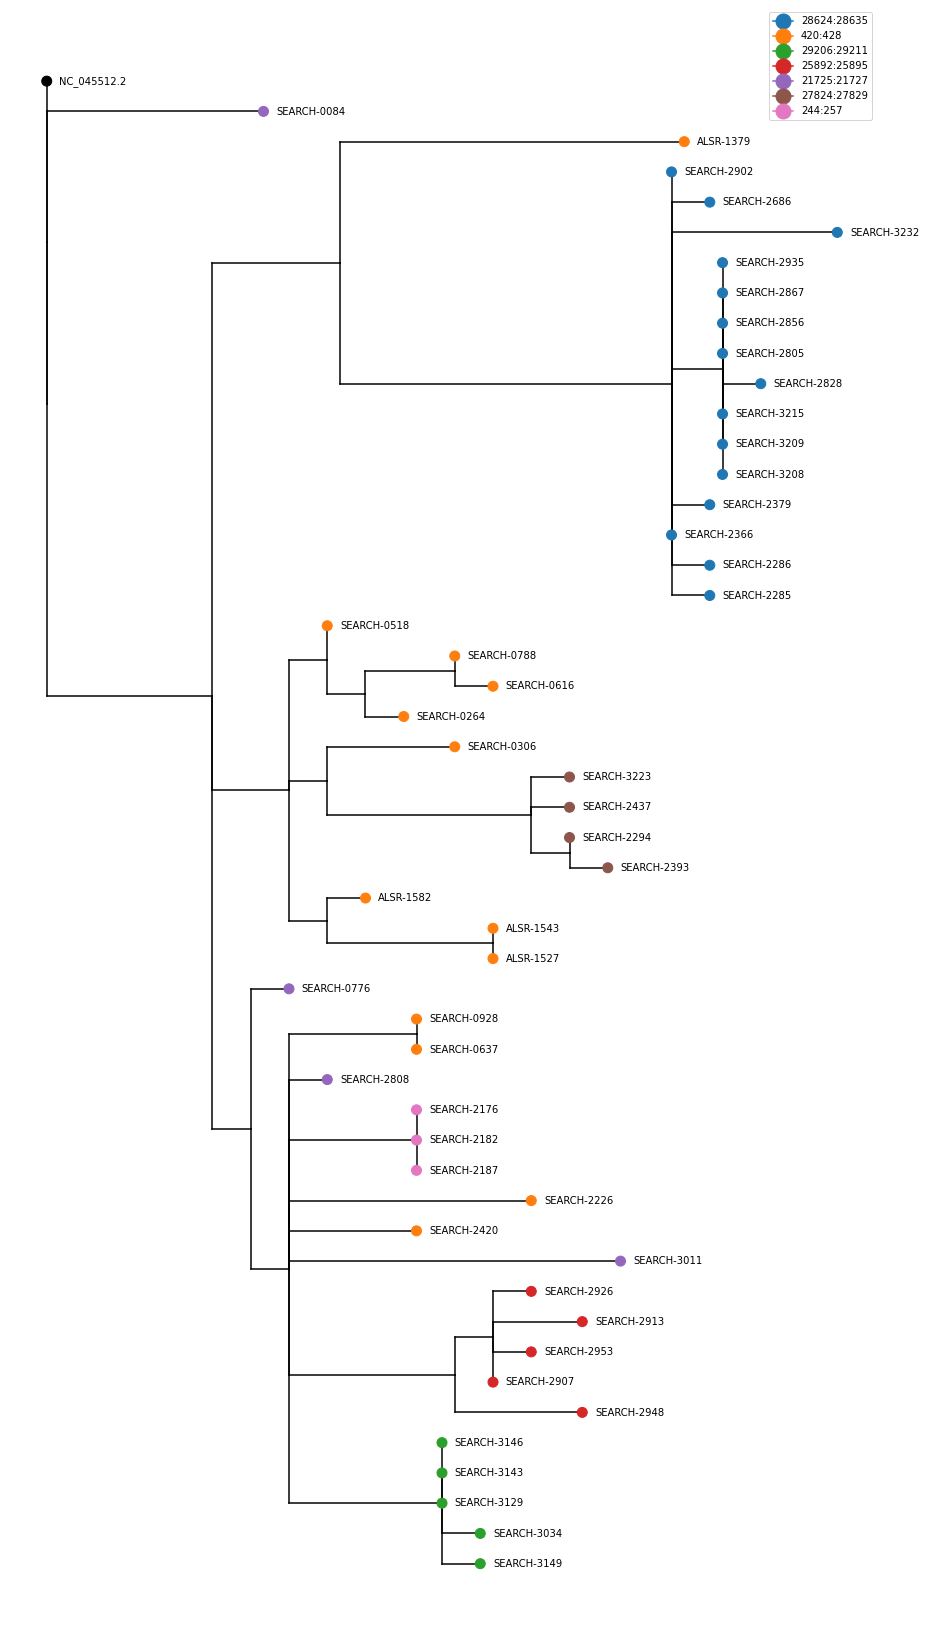

In [59]:
f = plt.figure()
gs = gridspec.GridSpec(2, 2, width_ratios=[1,0.75], height_ratios = [0.5,0.5])

ax = plt.subplot(gs[:,0])
for i in deletion_tree.get_nonterminals():
    for j in i.clades:
        _t = ax.plot([i.x, i.x], [i.y, j.y], ls='-', color="#000000", zorder = 1)
        _t = ax.plot([i.x, j.x], [j.y, j.y], ls='-', color="#000000", zorder = 1)

_ = {
    "x": [],
    "y": [],
    "c": []
}
for i in deletion_tree.get_terminals():
    _["x"].append(i.x)
    _["y"].append(i.y)
    _["c"].append(sample_colors.get(i.name, 'black'))
    
    ax.text(i.x+1e-5, i.y-1e-1, i.name)
#     _["c"].append(c)
    # ax.text(i.x+0.001, i.y, i.name.split("_")[3])
    # if i.name in hp["taxon name"].tolist():
    #     ax.text(i.x + 0.000025, i.y, i.name.split("_")[0] + " " + str(hp[hp["taxon name"] == i.name]["#of homoplasic mutations"].values[0]))
# ax.text(_["x"], _["y"], _["text"])
ax.scatter(_["x"], _["y"], c = _["c"], s = 100, zorder = 2)
ax.scatter(_["x"], _["y"], c = _["c"], s = 50, zorder = 2)
ax.legend(handles=legend_elements)
f.patch.set_visible(False)
ax.axis('off')
plt.show()

## Visualizing Deletions
The code blocks below should define the sequence of logical steps to generate visualizations of deletions that are identified from MSAs of consensus sequences. 

## TODO:
* tree with samples annotated based on INDELs in their consensus sequences
* tree pruning functionality
    * collapse branches **not** containing samples with `indel`s
    * represent each collapsed branch as a terminal node annotated with number of constituent samples 
* iSNV 'Layered' information
    * fetch iSNVs for each sample
    * filter out `indel`s 
    * create function that updates tree annotations based on iSNV `indel`s and user-specified frequency threshold
* allow for multiple annotations per sample
    * each `indel` type associated with a specific color
    * each `sample` annotated with a sequence of colors corresponding to the `indel`s they possess
    * most common `indel` annotates the sample node, and the remaining `indels` annotate the flag sequence


In [3]:
# %load_ext rpy2.ipython

In [4]:
# %%R 

# library(ggplot2)
# library(ggtree)
# library(castor)
# library(TreeTools)

In [5]:
# %%R


# # setwd("")

# nwk <- (tree_path)
# tree <- read.tree(nwk)
# rtree <- tree.root(names=outgroup)
# # find_root(tree)
# # ggtree (tree)

In [7]:
# %%R
# outgroup = "NC_045512.2"
# tree2 = root_via_outgroup(tree, outgroup)
# tree2

In [8]:
# %%R
# tree2 = RootTree(tree, outgroup)
# tree2

In [9]:
# %%R 
# # find_root(tree2)

# ggtree (tree2)

In [10]:
# %%R 
# tree.tiplabels

# p <- ggtree(tree) + 
#   xlim(0, 0.025) + # to allow more space for labels
#   geom_treescale() # adds the scale

# p %<+% dd + 
#   geom_tiplab(aes(fill = factor(cat)),
#               color = "black", # color for label font
#               geom = "label",  # labels not text
#               label.padding = unit(0.15, "lines"), # amount of padding around the labels
#               label.size = 0) + # size of label border

#   theme(legend.position = c(0.5,0.2), 
#         legend.title = element_blank(), # no title
#         legend.key = element_blank()) # no keys

In [43]:
deletions_path = '/Users/al/Documents/scripps/data/deletion_results_v3.csv'
dels = pd.read_csv(deletions_path)
dels.head()

,deletion,samples,del_length,num_samples
0,"[28624, 28625, 28626, 28627, 28628, 28629, 286...",['SEARCH-2285' 'SEARCH-2286' 'SEARCH-2366' 'SE...,12,15
1,"[420, 421, 422, 423, 424, 425, 426, 427, 428]",['SEARCH-2420' 'SEARCH-2226' 'SEARCH-0264' 'SE...,9,13
2,[27526],['SEARCH-2199' 'SEARCH-2200' 'SEARCH-2208' 'SE...,1,5
3,"[29206, 29207, 29208, 29209, 29210, 29211]",['SEARCH-3149' 'SEARCH-3034' 'SEARCH-3129' 'SE...,6,5
4,"[25892, 25893, 25894, 25895]",['SEARCH-2948' 'SEARCH-2907' 'SEARCH-2953' 'SE...,4,5


In [64]:
ans.shape

(86, 4)

In [37]:
# ans['samples'] = ans['samples'].apply(lambda x: x[1:-1].split())

In [38]:
# dels.dtypes

In [45]:
dels['samples'] = dels['samples'].apply(lambda x: x[1:-1].split())

In [40]:
# eval(dels['deletion'].values[0])

In [41]:
def get_deletion_coord(x):
    min_pos = np.min(eval(x))
    max_pos = np.max(eval(x))
    return f'{min_pos}:{max_pos}'
dels['deletion_id'] = dels['deletion'].apply(get_deletion_coord)

In [42]:
dels[dels['del_length'] > 1]

,deletion,samples,del_length,num_samples,deletion_id
0,"[28624, 28625, 28626, 28627, 28628, 28629, 286...","['SEARCH-2285', 'SEARCH-2286', 'SEARCH-2366', ...",12,15,28624:28635
1,"[420, 421, 422, 423, 424, 425, 426, 427, 428]","['SEARCH-2420', 'SEARCH-2226', 'SEARCH-0264', ...",9,13,420:428
3,"[29206, 29207, 29208, 29209, 29210, 29211]","['SEARCH-3149', 'SEARCH-3034', 'SEARCH-3129', ...",6,5,29206:29211
4,"[25892, 25893, 25894, 25895]","['SEARCH-2948', 'SEARCH-2907', 'SEARCH-2953', ...",4,5,25892:25895
6,"[21725, 21726, 21727]","['SEARCH-3011', 'SEARCH-2808', 'SEARCH-0084', ...",3,4,21725:21727
7,"[27824, 27825, 27826, 27827, 27828, 27829]","['SEARCH-2393', 'SEARCH-2437', 'SEARCH-2294', ...",6,4,27824:27829
9,"[244, 245, 246, 247, 248, 249, 250, 251, 252, ...","['SEARCH-2187', 'SEARCH-2182', 'SEARCH-2176']",14,3,244:257
10,"[249, 250, 251, 252, 253, 254]","['SEARCH-2611', 'SEARCH-0007', 'SEARCH-0438']",6,3,249:254
11,"[21893, 21894, 21895]","['SEARCH-2287', 'SEARCH-2731']",3,2,21893:21895
12,"[27799, 27800, 27801]","['SEARCH-2162', 'SEARCH-2093']",3,2,27799:27801


In [16]:
top_dels = dels.nlargest(10, 'num_samples')

In [17]:
top_dels

,deletion,samples,del_length,num_samples,deletion_id
0,"[28624, 28625, 28626, 28627, 28628, 28629, 286...","['SEARCH-2285', 'SEARCH-2286', 'SEARCH-2366', ...",12,15,28624:28635
1,"[420, 421, 422, 423, 424, 425, 426, 427, 428]","['SEARCH-2420', 'SEARCH-2226', 'SEARCH-0264', ...",9,13,420:428
2,[27526],"['SEARCH-2199', 'SEARCH-2200', 'SEARCH-2208', ...",1,5,27526:27526
3,"[29206, 29207, 29208, 29209, 29210, 29211]","['SEARCH-3149', 'SEARCH-3034', 'SEARCH-3129', ...",6,5,29206:29211
4,"[25892, 25893, 25894, 25895]","['SEARCH-2948', 'SEARCH-2907', 'SEARCH-2953', ...",4,5,25892:25895
5,[27988],"['SEARCH-2498', 'SEARCH-2518', 'SEARCH-3150', ...",1,4,27988:27988
6,"[21725, 21726, 21727]","['SEARCH-3011', 'SEARCH-2808', 'SEARCH-0084', ...",3,4,21725:21727
7,"[27824, 27825, 27826, 27827, 27828, 27829]","['SEARCH-2393', 'SEARCH-2437', 'SEARCH-2294', ...",6,4,27824:27829
8,[178],"['SEARCH-2187', 'SEARCH-2182', 'SEARCH-2176']",1,3,178:178
9,"[244, 245, 246, 247, 248, 249, 250, 251, 252, ...","['SEARCH-2187', 'SEARCH-2182', 'SEARCH-2176']",14,3,244:257


In [16]:
top_dels = top_dels.loc[top_dels['del_length']>1]

In [17]:
# colors = ['red', 'yellow', 'green', 'blue', 'orange']

In [18]:
del2color = {}
for i, td in enumerate(top_dels.iterrows()):
#     print(td[1]['deletion_id'])
    deletion = td[1]['deletion_id']
    del2color[deletion] = colors[i]
del2color
#     print(td)

{'28624:28635': 'tab:blue',
 '420:428': 'tab:orange',
 '29206:29211': 'tab:green',
 '25892:25895': 'tab:red',
 '21725:21727': 'tab:purple',
 '27824:27829': 'tab:brown',
 '244:257': 'tab:pink'}

In [19]:
sample_colors = {}
for i, td in enumerate(top_dels.iterrows()):
    deletion = td[1]['deletion_id']
    samples = td[1]['samples']
    for sample in samples:
        sample_colors[eval(sample)] = del2color[deletion]
len(sample_colors)

49

In [20]:
# list(sample_colors.keys())

In [21]:
# sample_colors

In [22]:
del2color

{'28624:28635': 'tab:blue',
 '420:428': 'tab:orange',
 '29206:29211': 'tab:green',
 '25892:25895': 'tab:red',
 '21725:21727': 'tab:purple',
 '27824:27829': 'tab:brown',
 '244:257': 'tab:pink'}

In [23]:
legend_elements = [Line2D([0], [0], marker='o', color=x, label=y,
                          markerfacecolor=x, markersize=15) for y, x in del2color.items()]
legend_elements

In [24]:
# plt.ion()

## TODO:
* regenerate tree using matplotlib (use KGs script for reference)
* collapse branches

In [76]:
tree_path = "/Users/al/Documents/scripps/data/aligned_seqs/2020-09-17_all_renamed_aligned_deduplicated.fa.treefile"

In [77]:
tree = next(Phylo.parse(tree_path, 'newick'))
tree.rooted

False

In [78]:
# root with genome from patient zero
root_name = 'NC_045512.2'
tree.root_with_outgroup(root_name)
tree.rooted

True

In [79]:
len(tree.get_terminals())

1869

In [80]:
def prune_clade(clade: Phylo.Newick.Clade, samples_of_interest: list) -> bool:
    sample_names = [leaf.name for leaf in clade.get_terminals()]
    common_names = set(sample_names) & set(samples_of_interest)
    if len(common_names) == 0:
        return True
    return False

In [81]:
prune_samples = set()
for clade in tree.get_nonterminals():
    if prune_clade(clade, deletion_samples):
        prune_samples.update([leaf for leaf in clade.get_terminals()])
print(len(prune_samples))

1462


In [82]:
for sample in prune_samples:
    tree.prune(sample)

In [83]:
len(tree.get_terminals())

407

In [84]:
def get_coords(tree):
    for _i, i in enumerate(tree.get_terminals()):
        i.y = _i
        i.x = tree.distance(i)

    for i in reversed(tree.get_nonterminals()):
        _ = i.clades
        i.y = (_[0].y + _[-1].y)/2
        i.x = tree.distance(i)
    return tree

In [85]:
tree = get_coords(tree)

In [86]:
plt.rcParams["figure.figsize"] = (40,100)

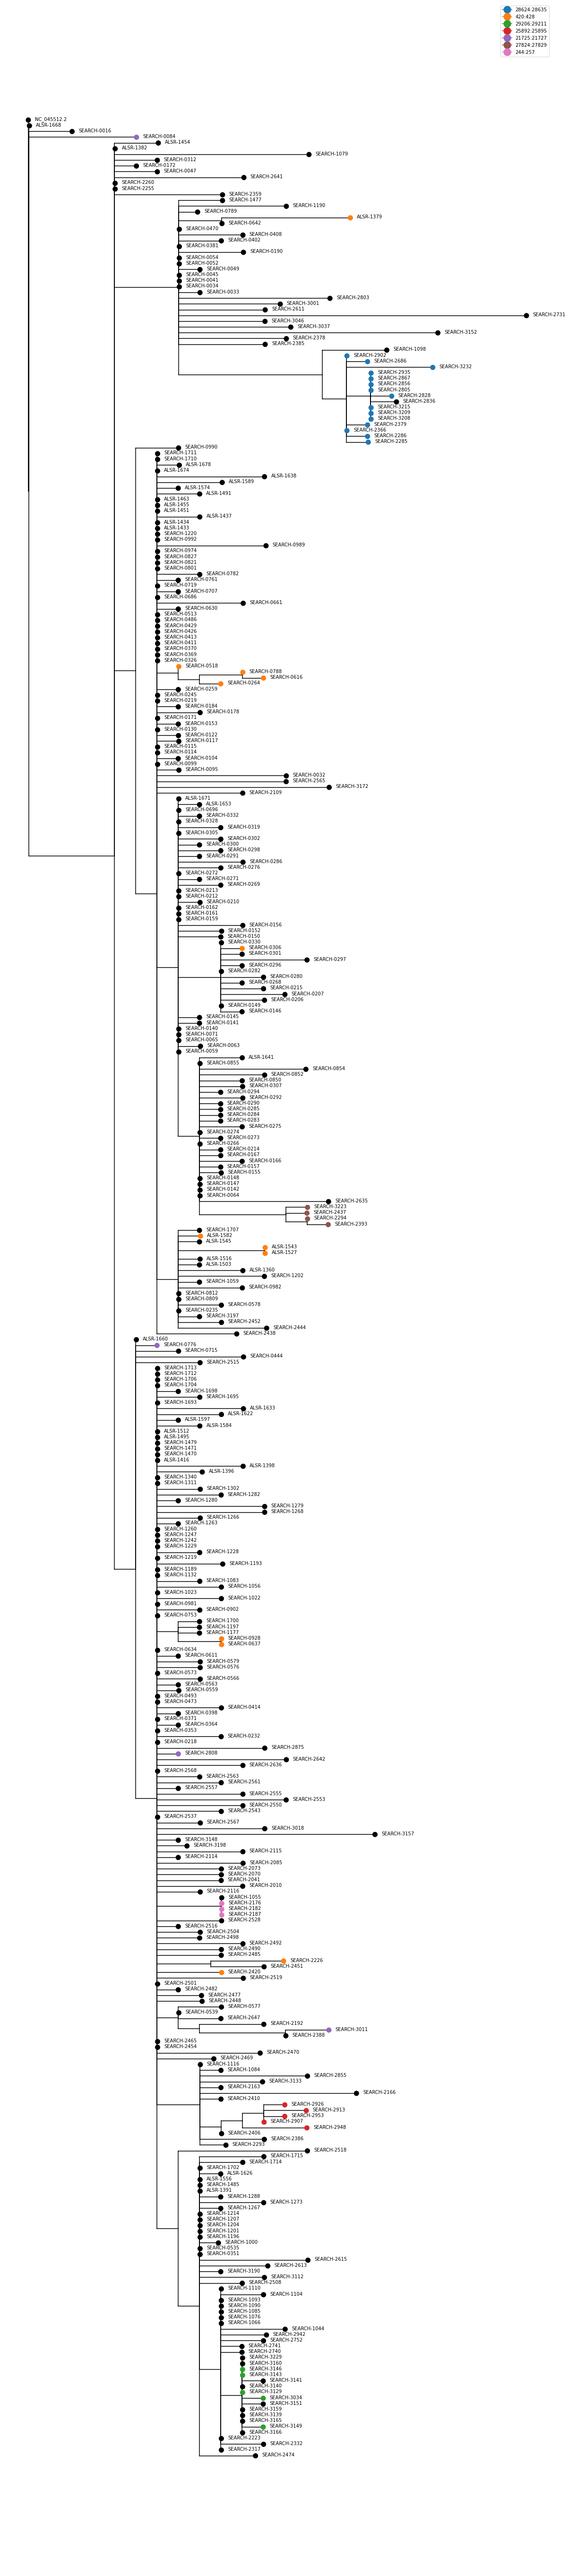

In [88]:
f = plt.figure()
gs = gridspec.GridSpec(2, 2, width_ratios=[1,0.75], height_ratios = [0.5,0.5])

ax = plt.subplot(gs[:,0])
for i in tree.get_nonterminals():
    for j in i.clades:
#         if prune_clade(j, deletion_samples): continue
        _t = ax.plot([i.x, i.x], [i.y, j.y], ls='-', color="#000000", zorder = 1)
        _t = ax.plot([i.x, j.x], [j.y, j.y], ls='-', color="#000000", zorder = 1)
        
_ = {
    "x": [],
    "y": [],
    "c": []
}
for i in tree.get_terminals():
    _["x"].append(i.x)
    _["y"].append(i.y)
    _["c"].append(sample_colors.get(i.name, 'black'))
    
    ax.text(i.x+1e-5, i.y-1e-1, i.name)
#     _["c"].append(c)
    # ax.text(i.x+0.001, i.y, i.name.split("_")[3])
    # if i.name in hp["taxon name"].tolist():
    #     ax.text(i.x + 0.000025, i.y, i.name.split("_")[0] + " " + str(hp[hp["taxon name"] == i.name]["#of homoplasic mutations"].values[0]))
# ax.text(_["x"], _["y"], _["text"])
ax.scatter(_["x"], _["y"], c = _["c"], s = 100, zorder = 2)
ax.scatter(_["x"], _["y"], c = _["c"], s = 50, zorder = 2)
ax.legend(handles=legend_elements)
f.patch.set_visible(False)
ax.axis('off')
plt.show()

In [25]:
# plt.rcParams["figure.figsize"] = (20,350)

In [26]:
# fig = plt.figure()
# axes = fig.add_subplot(1, 1, 1)
# # axes.legend(handles=legend_elements)
# Phylo.draw(tree, label_colors=sample_colors, axes=axes, do_show=False)
# plt.savefig('deletion_tree.svg')
# plt.show()

In [32]:
tree_str = tree.format('newick')

In [33]:
dtree = dendropy.Tree.get_from_string(
        tree_str[:-1],
        rooting="default-rooted",
        schema="newick")

In [35]:
# for i in tree.get_nonterminals():
#     print(i)

In [36]:
samples2ignore = []
deletion_samples = list(sample_colors.keys())
for i in tree.get_nonterminals():
    for j in i.clades:
        
        if prune_clade(j, deletion_samples):
            samples2ignore += [s.name for s in j.get_terminals()]

NameError: name 'prune_clade' is not defined

In [145]:
len([t.name for t in tree.get_terminals()])

1869

In [146]:
len(set(samples2ignore))

1820

In [147]:
# print(tree.as_ascii_plot())

In [148]:
# tree.retain_taxa_with_labels(deletion_samples + ['NC 045512.2'])

In [149]:
# with open('deletion_tree.treefile', 'w') as f:
#     f.write(tree.as_string('newick'))

In [150]:
type(tree)

Bio.Phylo.Newick.Tree

In [56]:
from io import StringIO

deletion_tree = Phylo.read('deletion_tree.treefile', "newick")
root_name = 'NC_045512.2'
deletion_tree.root_with_outgroup(root_name)
deletion_tree

Tree(rooted=True, weight=1.0)

In [66]:
len(tree.get_terminals())

407

In [46]:
len(sample_colors.keys())

49

In [47]:
deletion_samples = list(sample_colors.keys())
# prune_clade(clade, deletion_samples)

In [48]:
# clade

In [49]:
plt.rcParams["figure.figsize"] = (20,250)

In [50]:
tree = get_coords(tree)

In [51]:
samples = [s.name for s in tree.get_terminals()]

In [52]:
samples2ignore = set(samples) - set(deletion_samples)

In [57]:
deletion_tree = get_coords(deletion_tree)

In [58]:
plt.rcParams["figure.figsize"] = (30,30)

##TODO:
* collapsed branches (as terminal nodes) showing number of samples not shown

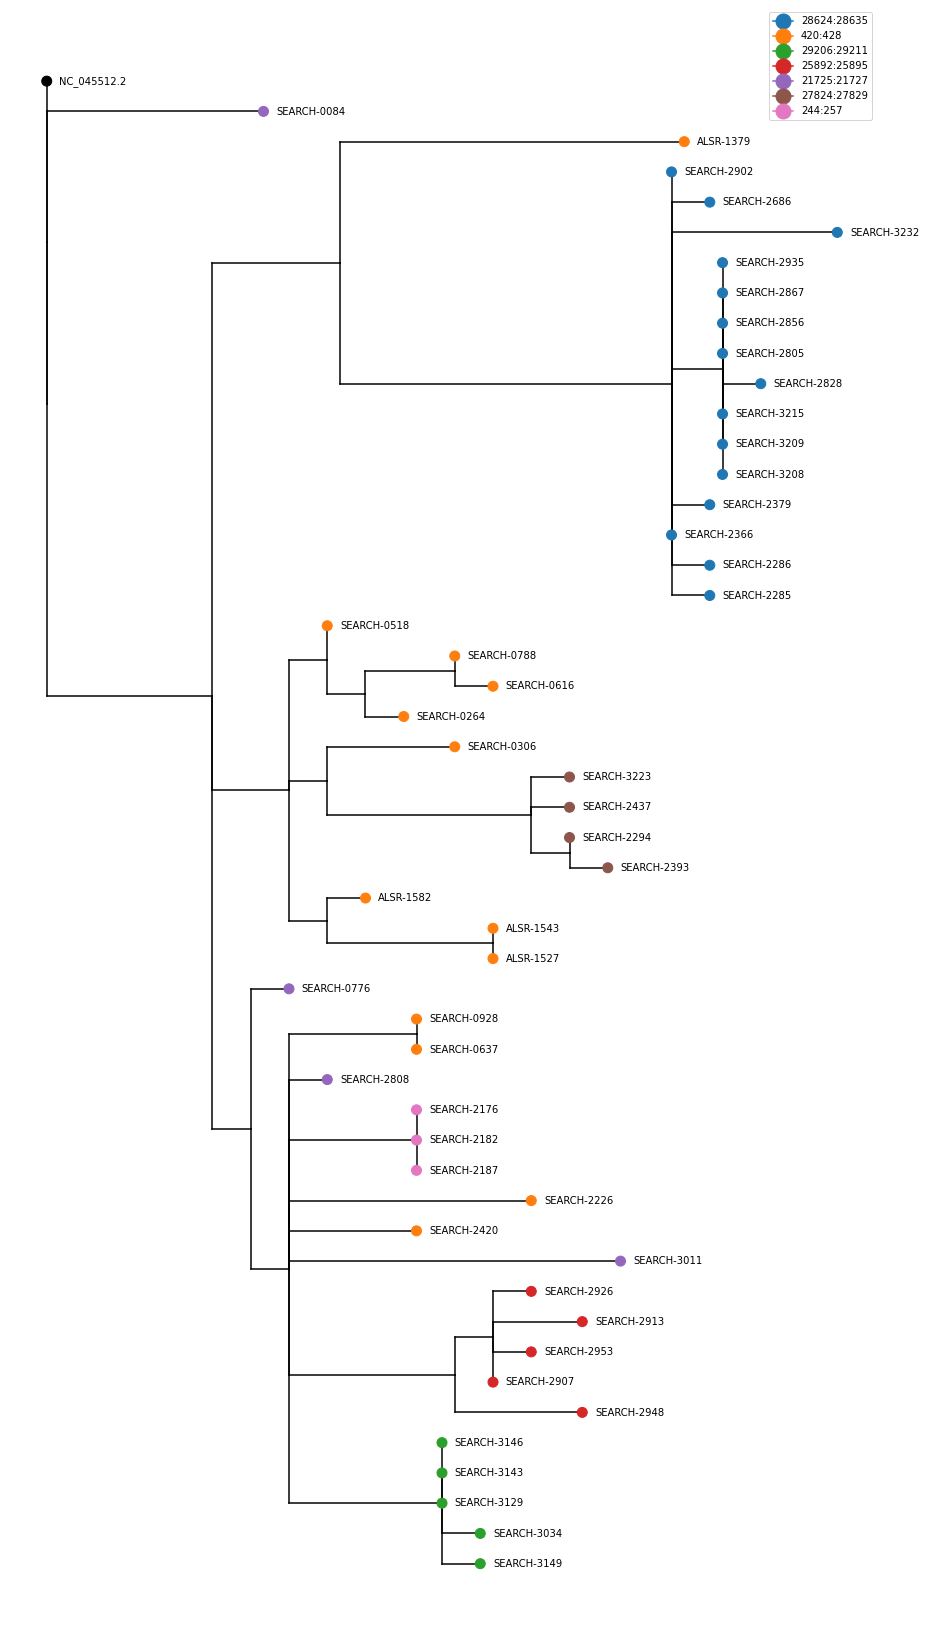

In [59]:
f = plt.figure()
gs = gridspec.GridSpec(2, 2, width_ratios=[1,0.75], height_ratios = [0.5,0.5])

ax = plt.subplot(gs[:,0])
for i in deletion_tree.get_nonterminals():
    for j in i.clades:
        _t = ax.plot([i.x, i.x], [i.y, j.y], ls='-', color="#000000", zorder = 1)
        _t = ax.plot([i.x, j.x], [j.y, j.y], ls='-', color="#000000", zorder = 1)

_ = {
    "x": [],
    "y": [],
    "c": []
}
for i in deletion_tree.get_terminals():
    _["x"].append(i.x)
    _["y"].append(i.y)
    _["c"].append(sample_colors.get(i.name, 'black'))
    
    ax.text(i.x+1e-5, i.y-1e-1, i.name)
#     _["c"].append(c)
    # ax.text(i.x+0.001, i.y, i.name.split("_")[3])
    # if i.name in hp["taxon name"].tolist():
    #     ax.text(i.x + 0.000025, i.y, i.name.split("_")[0] + " " + str(hp[hp["taxon name"] == i.name]["#of homoplasic mutations"].values[0]))
# ax.text(_["x"], _["y"], _["text"])
ax.scatter(_["x"], _["y"], c = _["c"], s = 100, zorder = 2)
ax.scatter(_["x"], _["y"], c = _["c"], s = 50, zorder = 2)
ax.legend(handles=legend_elements)
f.patch.set_visible(False)
ax.axis('off')
plt.show()

In [14]:
tree = toytree.tree(tree_path)

In [15]:
rtree = tree.root(names='NC_045512.2')

In [69]:
toytree.colors

['rgba(40.0%,76.1%,64.7%,1.000)',
 'rgba(98.8%,55.3%,38.4%,1.000)',
 'rgba(55.3%,62.7%,79.6%,1.000)',
 'rgba(90.6%,54.1%,76.5%,1.000)',
 'rgba(65.1%,84.7%,32.9%,1.000)',
 'rgba(100.0%,85.1%,18.4%,1.000)',
 'rgba(89.8%,76.9%,58.0%,1.000)',
 'rgba(70.2%,70.2%,70.2%,1.000)']

In [17]:
# rtree.get_tip_labels()

In [43]:
# dir(rtree)

In [19]:
rtree.draw(tip_labels_align=False, height=5000, 
           layout='c')

(<toyplot.canvas.Canvas at 0x7fc6f518b100>,
 <toytree.Render.ToytreeMark at 0x7fc6f837b820>)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="5000.0px" height="5000.0px" viewBox="0 0 5000.0 5000.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tc073a554956a47c99074acbed3fcbfc6"> <path d="M 2764.0 1737.8 L 2760.4 1748.0 A 795.9 795.9 0 0 1 2764.4 1740.5" id=

In [26]:
(dels.explode('samples')
 .groupby('samples')
 .agg(dels=('deletion_id', 'unique'), 
      num_dels=('deletion_id', 'nunique'))
 .sort_values('num_dels', ascending=False))

,dels,num_dels
samples,,
'SEARCH-2187',"[178:178, 244:257, 1338:1338]",3
'SEARCH-2731',"[21893:21895, 242:256, 10102:10102]",3
'SEARCH-2438',"[23745:23760, 23585:23585, 22618:22621]",3
'SEARCH-2442',"[29329:29347, 29174:29195]",2
'SEARCH-2532',"[17079:17083, 16935:16953]",2
...,...,...
'SEARCH-0928',[420:428],1
'SEARCH-0854',[3065:3082],1
'SEARCH-0851',[13345:13346],1


In [27]:
print(dels.explode('samples').shape)
print(dels.explode('samples')['samples'].value_counts()[:14])

(147, 5)
'SEARCH-2438'    3
'SEARCH-2187'    3
'SEARCH-2731'    3
'SEARCH-2226'    2
'SEARCH-2626'    2
'SEARCH-2442'    2
'SEARCH-3109'    2
'SEARCH-2469'    2
'SEARCH-0142'    2
'SEARCH-2532'    2
'SEARCH-0068'    2
'SEARCH-2176'    2
'SEARCH-2182'    2
'SEARCH-2200'    1
Name: samples, dtype: int64


## Identifying Deletions 
The code blocks below define the sequence of logical steps to identify common deletions from a MSA of consensus sequences from different samples.

In [14]:
filepath = "/Users/al/Documents/scripps/data/aligned_seqs/2020-09-17_all_renamed_aligned_deduplicated.fa"

In [15]:
# %debug
d = AlignIO.read(filepath, 'fasta')
seqs = {}
for row in d:
    sample_idx = str(row.id)
    s = str(row.seq)
    seqs[sample_idx] = s[265:29674]
len(seqs)

1869

In [16]:
len(str(row.seq)[265:29674])

29409

In [17]:
row.id

'SEARCH-1715'

In [19]:
seqsdf = (pd.DataFrame(index=seqs.keys(), data=seqs.values(), columns=['sequence'])
            .reset_index().rename(columns={'index': 'idx'}))

In [20]:
seqsdf.head()

,idx,sequence
0,NC_045512.2,atggagagccttgtccctggtttcaacgagaaaacacacgtccaac...
1,SEARCH-1988,atggagagccttgtccctggtttcaacgagaaaacacacgtccaac...
2,SEARCH-1989,atggagagccttgtccctggtttcaacgagaaaacacacgtccaac...
3,SEARCH-1990,atggagagccttgtccctggtttcaacgagaaaacacacgtccaac...
4,SEARCH-1991,atggagagccttgtccctggtttcaacgagaaaacacacgtccaac...


In [21]:
print(seqsdf.shape)
seqsdf['seq_len'] = seqsdf['sequence'].str.len()
print(seqsdf['seq_len'].unique())
seqsdf.head()

(1869, 2)
[29409]


,idx,sequence,seq_len
0,NC_045512.2,atggagagccttgtccctggtttcaacgagaaaacacacgtccaac...,29409
1,SEARCH-1988,atggagagccttgtccctggtttcaacgagaaaacacacgtccaac...,29409
2,SEARCH-1989,atggagagccttgtccctggtttcaacgagaaaacacacgtccaac...,29409
3,SEARCH-1990,atggagagccttgtccctggtttcaacgagaaaacacacgtccaac...,29409
4,SEARCH-1991,atggagagccttgtccctggtttcaacgagaaaacacacgtccaac...,29409


In [22]:
def find_del_positions(x):
    return [m.start() for m in re.finditer('-', x)]

def find_deletions(x):
    del_positions = [m.start() for m in re.finditer('-', x)]
    return [list(map(itemgetter(1), g)) for k, g in groupby(enumerate(del_positions), 
                                                            lambda x: x[0]-x[1])]

In [23]:
seqsdf['del_positions'] = seqsdf['sequence'].apply(find_deletions)
del_seqs = seqsdf.loc[seqsdf['del_positions'].str.len() > 0]

In [24]:
del_seqs.columns

Index(['idx', 'sequence', 'seq_len', 'del_positions'], dtype='object')

In [25]:
del_seqs = del_seqs.explode('del_positions')
del_seqs.head()

,idx,sequence,seq_len,del_positions
8,SEARCH-2413,atggagagccttgtccctggtttcaacgagaaaacacacgtccaac...,29409,[8606]
9,SEARCH-2418,atggagagccttgtccctggtttcaacgagaaaacacacgtccaac...,29409,[22751]
12,SEARCH-2311,atggagagccttgtccctggtttcaacgagaaaacacacgtccaac...,29409,[4499]
13,SEARCH-2469,atggagagccttgtccctggtttcaacgagaaaacacacgtccaac...,29409,[13719]
13,SEARCH-2469,atggagagccttgtccctggtttcaacgagaaaacacacgtccaac...,29409,[13727]


In [26]:
def cross_join(df1: pd.DataFrame, df2: pd.DataFrame) -> pd.DataFrame:
    df1 = df1.assign(key=0)
    df2 = df2.assign(key=0)
    return pd.merge(df1, df2, on='key').drop(columns='key')

def is_deletion_common(x):
    return x['del_positions_x']==x['del_positions_y']

In [27]:
del_matrix = cross_join(del_seqs[['idx', 'del_positions']], del_seqs[['idx', 'del_positions']])
del_matrix['common_deletion'] = del_matrix.apply(is_deletion_common, axis=1)
del_matrix['del_length'] = del_matrix['del_positions_x'].str.len()
del_filter = ((del_matrix['common_deletion']==True) & 
              (del_matrix['del_length']>0))
#               & 
#               (del_matrix['idx_x']!=del_matrix['idx_y']))
del_matrix = del_matrix.loc[del_filter]

In [28]:
print(del_matrix.shape)
del_matrix.head()

(643, 6)


,idx_x,del_positions_x,idx_y,del_positions_y,common_deletion,del_length
0,SEARCH-2413,[8606],SEARCH-2413,[8606],True,1
148,SEARCH-2418,[22751],SEARCH-2418,[22751],True,1
296,SEARCH-2311,[4499],SEARCH-2311,[4499],True,1
444,SEARCH-2469,[13719],SEARCH-2469,[13719],True,1
592,SEARCH-2469,[13727],SEARCH-2469,[13727],True,1


In [29]:
del_matrix['deletion'] = del_matrix['del_positions_x'].astype(str)
ans = (del_matrix.groupby('deletion')
       .agg(samples=('idx_x', 'unique'), 
            del_length=('del_length', 'mean'))
       .reset_index())
ans['num_samples'] = ans['samples'].str.len()
ans.sort_values('num_samples', ascending=False, inplace=True)

In [30]:
ans.shape

(86, 4)

In [31]:
ans

,deletion,samples,del_length,num_samples
65,"[28624, 28625, 28626, 28627, 28628, 28629, 286...","[SEARCH-2285, SEARCH-2286, SEARCH-2366, SEARCH...",12,15
74,"[420, 421, 422, 423, 424, 425, 426, 427, 428]","[SEARCH-2420, SEARCH-2226, SEARCH-0264, SEARCH...",9,13
59,[27526],"[SEARCH-2199, SEARCH-2200, SEARCH-2208, SEARCH...",1,5
68,"[29206, 29207, 29208, 29209, 29210, 29211]","[SEARCH-3149, SEARCH-3034, SEARCH-3129, SEARCH...",6,5
42,"[25892, 25893, 25894, 25895]","[SEARCH-2948, SEARCH-2907, SEARCH-2953, SEARCH...",4,5
...,...,...,...,...
28,"[23577, 23578]",[SEARCH-2155],2,1
27,"[23289, 23290, 23291, 23292, 23293, 23294, 232...",[ALSR-1679],28,1
26,[22751],[SEARCH-2418],1,1
25,"[22618, 22619, 22620, 22621]",[SEARCH-2438],4,1


In [109]:
ans.to_csv('/Users/alaa/Documents/scripps/data/deletion_results_v3.csv', index=False)
ans.to_excel('/Users/alaa/Documents/scripps/data/deletion_results_v3.xlsx', index=False)

In [42]:
for i in range(33):
    num_samples = ans2.iloc[i, :]['num_samples']
    samples = ans2.iloc[i, :]['samples']
    deletion = ans2.iloc[i, :]['common_del_positions']
    
    print(num_samples, deletion, samples)
    print('\n')

15 [28624, 28625, 28626, 28627, 28628, 28629, 28630, 28631, 28632, 28633, 28634, 28635] ['SEARCH-3208' 'SEARCH-2902' 'SEARCH-3209' 'SEARCH-2856' 'SEARCH-2805'
 'SEARCH-2828' 'SEARCH-2686' 'SEARCH-3215' 'SEARCH-3232' 'SEARCH-2286'
 'SEARCH-2366' 'SEARCH-2379' 'SEARCH-2285' 'SEARCH-2867' 'SEARCH-2935']


13 [420, 421, 422, 423, 424, 425, 426, 427, 428] ['SEARCH-0637' 'SEARCH-0616' 'SEARCH-0306' 'SEARCH-0264' 'SEARCH-0518'
 'ALSR-1527' 'ALSR-1543' 'ALSR-1379' 'SEARCH-0928' 'SEARCH-2226'
 'SEARCH-0788' 'ALSR-1582' 'SEARCH-2420']


9 [252, 253, 254] ['SEARCH-2176' 'SEARCH-2731' 'SEARCH-0979' 'SEARCH-2611' 'SEARCH-0491'
 'SEARCH-2187' 'SEARCH-2182' 'SEARCH-0007' 'SEARCH-0438']


8 [249, 250, 251, 252, 253, 254] ['SEARCH-2187' 'SEARCH-2731' 'SEARCH-2611' 'SEARCH-0438' 'SEARCH-0491'
 'SEARCH-2176' 'SEARCH-2182' 'SEARCH-0007']


7 [244, 245, 246, 247, 248, 249, 250, 251, 252] ['SEARCH-0174' 'SEARCH-0320' 'SEARCH-0491' 'SEARCH-2176' 'SEARCH-2187'
 'SEARCH-2182' 'SEARCH-2731']


7 [25892, 25893, 